In [1]:
#参考https://blog.csdn.net/u010041824/article/details/78855435  by BabY虎子
import numpy as np
import pandas as pd

PARTICIPANT_ID='Sub01'

df_csv=pd.read_csv('data/Provo_Corpus-Eyetracking_Data(sub1-10).csv',
                   usecols=['Participant_ID','Text_ID','Word_Cleaned','IA_SKIP','Word_Length'])
df_csv=df_csv[(df_csv['Participant_ID']==PARTICIPANT_ID)]
df_csv=df_csv.drop(['Participant_ID'],axis=1) #删除列，轴为1
df_csv['Word_Length']=df_csv['Word_Length'].fillna('0')
df_csv['Word_Length']=df_csv['Word_Length'].astype('int32')
df_csv=df_csv.fillna(' ')

list_data=[]
for j in range(1,56): #句子1-55
    df=df_csv[(df_csv['Text_ID']==j)][['Word_Cleaned','IA_SKIP','Word_Length']] #只保留'Word_Cleaned','IA_SKIP'两列
    mylist = np.array(df).tolist()
    list_data.append(mylist)

texts=[[j[0] for j in i]for i in list_data]
labels=[[j[1] for j in i]for i in list_data]
wl=[[j[2] for j in i]for i in list_data]
#print(wl)

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NB_WORDS = 2000 #字典大小
MAX_SEQUENCE_LENGTH = max(len(s) for s in texts)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
MAX_NB_WORDS = len(word_index)+1 #重新修正字典大小
#print(word_index)
x = pad_sequences(sequences, MAX_SEQUENCE_LENGTH)  # left padding
x = np.expand_dims(x, 2) 
print(x)
print(x.shape)
y = pad_sequences(labels, MAX_SEQUENCE_LENGTH, value=-1)  # left padding
y = np.expand_dims(y, 2) 
#这是因为crf层期望标签具有不同的形状。
#通常，我们的标签的shape为(num_samples,max_length)，但crf层需要的shape为(num_samples,max_length,1)。
#解决方法：将标签扩一维
#https://blog.csdn.net/qq_31456593/article/details/89578018

#用Dense做激活层的时候，仍然需要这个expand_dims。
wl = pad_sequences(wl, MAX_SEQUENCE_LENGTH, value=-1)  # left padding
wl = np.expand_dims(wl, 2) 


print(y)
print(y.shape)
train_x=x[0:45]
train_y=y[0:45]
train_wl=wl[0:45]
test_x=x[45:]
test_y=y[45:]
test_wl=wl[45:]

Using TensorFlow backend.


[[[   0]
  [   0]
  [   0]
  ...
  [   3]
  [ 340]
  [   6]]

 [[   0]
  [ 160]
  [ 161]
  ...
  [  15]
  [ 363]
  [   6]]

 [[   0]
  [   0]
  [ 364]
  ...
  [ 377]
  [ 378]
  [   6]]

 ...

 [[   0]
  [   0]
  [   0]
  ...
  [  32]
  [  54]
  [   6]]

 [[   0]
  [   0]
  [   0]
  ...
  [1172]
  [ 120]
  [   6]]

 [[ 184]
  [1173]
  [1174]
  ...
  [1192]
  [   6]
  [   6]]]
(55, 60, 1)
[[[-1]
  [-1]
  [-1]
  ...
  [ 1]
  [ 0]
  [ 0]]

 [[-1]
  [ 0]
  [ 0]
  ...
  [ 1]
  [ 0]
  [ 0]]

 [[-1]
  [-1]
  [ 0]
  ...
  [ 0]
  [ 0]
  [ 0]]

 ...

 [[-1]
  [-1]
  [-1]
  ...
  [ 1]
  [ 0]
  [ 0]]

 [[-1]
  [-1]
  [-1]
  ...
  [ 0]
  [ 1]
  [ 0]]

 [[ 1]
  [ 1]
  [ 1]
  ...
  [ 0]
  [ 1]
  [ 0]]]
(55, 60, 1)


In [3]:

from keras.layers.merge import concatenate
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.layers import Embedding, Bidirectional, LSTM,Dense, Conv1D, MaxPooling1D,TimeDistributed,Flatten

INPUT_DIM = 1
TIME_STEPS = MAX_SEQUENCE_LENGTH
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = concatenate([inputs, a_probs], name='attention_mul')
    return output_attention_mul

def model_attention_applied_after_lstm(inputs):
#    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    return attention_mul
#    attention_mul = Flatten()(attention_mul)
#    output = Dense(1, activation='sigmoid')(attention_mul)
#    model = Model(input=[inputs], output=output)
#    return model

def model_attention_applied_before_lstm(inputs):
#    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=True)(attention_mul)#原例子中是return_sequences=False
    return attention_mul
#    output = Dense(1, activation='sigmoid')(attention_mul)
#    model = Model(input=[inputs], output=output)
#    return model

#model = model_attention_applied_after_lstm()
#model = model_attention_applied_before_lstm()
#inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
#lstm_units = 32
#lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
#attention_mul = model_attention_applied_before_lstm(inputs)
attention_mul = model_attention_applied_after_lstm(inputs)

Word_Length_input = Input(shape=(TIME_STEPS, INPUT_DIM,), name='world_length_input')
x =concatenate([attention_mul, Word_Length_input])
output = Dense(1, activation='sigmoid')(x)
model = Model(input=[inputs,Word_Length_input], output=output)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

#m.fit([inputs_1], outputs, epochs=1, batch_size=64, validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60, 1)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 60, 32)       4352        input_1[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 32, 60)       0           lstm_1[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 60)       0           permute_1[0][0]                  
_____________________________________

C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [4]:
EPOCHS = 15

# train model
train_history=model.fit([train_x,train_wl], train_y,batch_size=4,epochs=EPOCHS,  validation_data=([test_x,test_wl], test_y))
model.save('model/crf.h5')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 45 samples, validate on 10 samples
Epoch 1/15
45/45 [==============================] - 2s 41ms/step - loss: 0.7091 - acc: 0.3867 - val_loss: 0.6685 - val_acc: 0.5283
Epoch 2/15
45/45 [==============================] - 0s 11ms/step - loss: 0.6303 - acc: 0.5663 - val_loss: 0.6385 - val_acc: 0.5250
Epoch 3/15
45/45 [==============================] - 1s 11ms/step - loss: 0.5700 - acc: 0.5615 - val_loss: 0.6082 - val_acc: 0.5200
Epoch 4/15
45/45 [==============================] - 1s 12ms/step - loss: 0.4659 - acc: 0.5541 - val_loss: 0.5550 - val_acc: 0.5050
Epoch 5/15
45/45 [==============================] - 0s 11ms/step - loss: 0.2896 - acc: 0.5548 - val_loss: 0.4742 - val_acc: 0.5283
Epoch 6/15
45/45 [==============================] - 0s 11ms/step - loss: 0.1002 - acc: 0.5670 - val_loss: 0.3838 - val_acc: 0.5583
Epoch 7/15
45/45 [==========================

In [5]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'])
    plt.show()


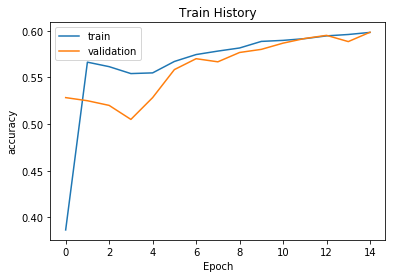

In [6]:
show_train_history(train_history,'acc','val_acc')